In [1]:
import os
import hopsworks

if os.environ.get("HOPSWORKS_API_KEY") is None:
    os.environ["HOPSWORKS_API_KEY"] = open(".hw_key").read()

project = hopsworks.login()
fs = project.get_feature_store()

2024-12-17 21:31:38,237 INFO: Initializing external client
2024-12-17 21:31:38,238 INFO: Base URL: https://c.app.hopsworks.ai:443
2024-12-17 21:31:39,620 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1157271


## Feature View Prep

In [2]:
delays_fg = fs.get_feature_group(
    name='delays',
    version=6,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=2,
)

In [ ]:
# Join delays and weather feature groups on arrival_time_bin and date respectively
selected_features = delays_fg.select_all().join(
    weather_fg.select_all(),
    left_on=['arrival_time_bin'],
    right_on=['date'],
    join_type='inner'
)
# Exclude rows with no delays
selected_features = selected_features.filter(selected_features['stop_count'] > 0)
selected_features.show(10)

In [ ]:
labels = ['mean_delay_change_seconds', 'max_delay_change_seconds', 'min_delay_change_seconds',
                         'var_delay_change_seconds',
                         'mean_arrival_delay_seconds', 'max_arrival_delay_seconds', 'min_arrival_delay_seconds',
                         'var_arrival_delay',
                         'mean_departure_delay_seconds', 'max_departure_delay_seconds',
                         'min_departure_delay_seconds', 'var_departure_delay',
                         'mean_on_time_percent', 'mean_final_stop_delay_seconds']
feature_view = fs.get_or_create_feature_view(
    name='delays_fv',
    description="weather features with delays as the target",
    version=4,
    labels=labels,
    query=selected_features,
)

## Data Split

In [1]:
feature_view = fs.get_feature_view(name='delays_fv', version=3)

# start_date_test_data = "2024-12-01"
# test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")
X_train, X_test, y_train, y_test = feature_view.train_test_split(test_size=0.2) # TODO: Use test_start instead of random split
X_train

NameError: name 'fs' is not defined

In [8]:
train_features = X_train.drop(['date', 'arrival_time_bin'], axis=1)
test_features = X_test.drop(['date', 'arrival_time_bin'], axis=1)

In [9]:
y_train

,mean_arrival_delay_seconds,max_arrival_delay_seconds,mean_departure_delay_seconds,max_departure_delay_seconds,on_time_mean_percent
0,126.493798,1623.0,142.773993,1627.0,84.419735
1,40.185331,1900.0,56.062272,2356.0,88.123916
2,105.430142,1178.0,118.684861,1313.0,86.251931
3,103.818072,3046.0,116.391907,3046.0,87.704609
4,77.122595,3594.0,87.217626,3610.0,89.995418
...,...,...,...,...,...
885,80.401747,2627.0,93.513368,2627.0,90.952537
886,50.285333,228.0,76.186804,228.0,92.854376
887,60.212707,487.0,73.025655,487.0,95.500530
888,100.725795,3221.0,111.560271,3221.0,86.799381


## Modeling

In [35]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# List of labels to predict
labels = ['mean_arrival_delay_seconds', 'max_arrival_delay_seconds', 'mean_departure_delay_seconds', 'max_departure_delay_seconds', 'on_time_mean_percent']

# Train a single model for all labels
xgb_regressor = XGBRegressor()
xgb_regressor.fit(train_features, y_train[labels])

y_pred = xgb_regressor.predict(test_features)

mse_scores = {}
r2_scores = {}
for i, label in enumerate(labels):
    mse = mean_squared_error(y_test[label], y_pred[:, i])
    mse_scores[label] = mse
    print(f"MSE for {label}: {mse}")

    r2 = r2_score(y_test[label], y_pred[:, i])
    r2_scores[label] = r2
    print(f"R squared for {label}: {r2}")

MSE for mean_arrival_delay_seconds: 464.8610994551002
R squared for mean_arrival_delay_seconds: 0.5890517997740967
MSE for max_arrival_delay_seconds: 949110.874890012
R squared for max_arrival_delay_seconds: 0.4264691637821365
MSE for mean_departure_delay_seconds: 618.0422808488545
R squared for mean_departure_delay_seconds: 0.512985609085407
MSE for max_departure_delay_seconds: 1184790.772986023
R squared for max_departure_delay_seconds: 0.3850478738005957
MSE for on_time_mean_percent: 41.830447921323994
R squared for on_time_mean_percent: -1.0873246770074068


In [36]:
# Dictionary to store models and their predictions
models = {}
predictions = {}
mse_scores = {}
r2_scores = {}

# Train a separate model for each label
for label in labels:
    xgb_regressor = XGBRegressor()
    xgb_regressor.fit(train_features, y_train[label])
    models[label] = xgb_regressor

    # Predicting target values on the test set
    y_pred = xgb_regressor.predict(test_features)
    predictions[label] = y_pred

    # Calculating Mean Squared Error (MSE) using sklearn
    mse = mean_squared_error(y_test[label], y_pred)
    mse_scores[label] = mse
    print(f"MSE for {label}: {mse}")

    # Calculating R squared using sklearn
    r2 = r2_score(y_test[label], y_pred)
    r2_scores[label] = r2
    print(f"R squared for {label}: {r2}")

MSE for mean_arrival_delay_seconds: 496.1851798178105
R squared for mean_arrival_delay_seconds: 0.5613605723001776
MSE for max_arrival_delay_seconds: 1141416.1171761267
R squared for max_arrival_delay_seconds: 0.31026252308779656
MSE for mean_departure_delay_seconds: 476.81751556582634
R squared for mean_departure_delay_seconds: 0.6242700554373718
MSE for max_departure_delay_seconds: 1316784.5048891818
R squared for max_departure_delay_seconds: 0.3165380339794518
MSE for on_time_mean_percent: 62.75470678125364
R squared for on_time_mean_percent: -2.1314378538150915


## Evaluation

In [39]:
df = y_test
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df.head(5)

,mean_arrival_delay_seconds,max_arrival_delay_seconds,mean_departure_delay_seconds,max_departure_delay_seconds,on_time_mean_percent,predicted_pm25,date,predicted
496,140.999132,2500.0,156.180651,2514.0,81.651511,82.891579,2023-02-06 07:00:00+00:00,82.891579
529,158.014187,2748.0,171.226525,2748.0,80.292035,85.660027,2023-02-06 18:00:00+00:00,85.660027
1,40.185331,1900.0,56.062272,2356.0,88.123916,87.127457,2023-02-06 23:00:00+00:00,87.127457
308,80.297276,897.0,92.743845,915.0,79.515061,86.392242,2024-09-01 01:00:00+00:00,86.392242
309,210.808691,1299.0,288.066845,1904.0,66.224676,48.317932,2024-09-30 22:00:00+00:00,48.317932


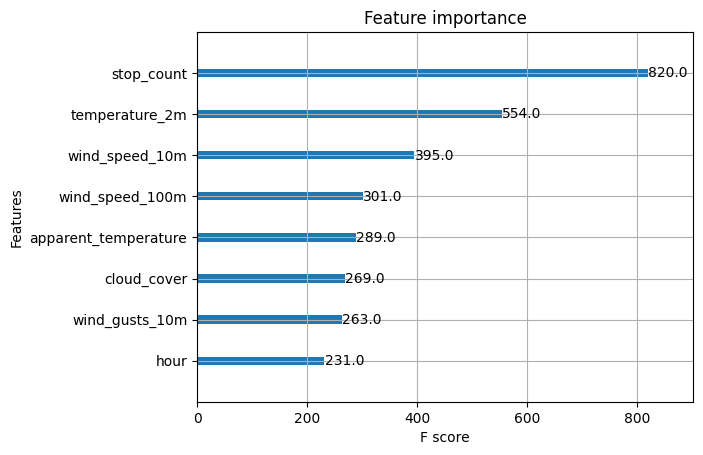

In [44]:
from matplotlib import pyplot as plt
from xgboost import plot_importance

plot_importance(xgb_regressor, max_num_features=8)
plt.show()

## Register Model

In [41]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

MODEL_DIR = "models/delays"

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

input_schema = Schema(X_train)
output_schema = Schema(y_train)

model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)
schema_dict = model_schema.to_dict()

xgb_regressor.save_model(MODEL_DIR + "/model.json")
res_dict = {
    "MSE": str(mse),
    "R squared": str(r2),
}

In [ ]:
mr = project.get_model_registry()

delays_model = mr.python.create_model(
    name="delays_xgboost_model",
    metrics= res_dict,
    model_schema=model_schema,
    input_example=X_test.sample().values,
    description="Delays predictor",
)

delays_model.save(MODEL_DIR + "/model.json")

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/373706 elapsed<00:00 remaining<?